## setup de l'environement

In [4]:
#from google.colab import drive
import os
import numpy as np
#drive.mount('/content/drive',force_remount=True)
os.chdir('/kaggle/input/celebamasked')


In [23]:
!ls /kaggle

In [ ]:
def replace(dir):
  for path in tqdm(os.listdir(dir)):
    out_path_X = os.path.join(dir,path)
    out_path_Y = os.path.join('_masked/',path.replace('_surgical', ''))
    os.rename(out_path_X,out_path_Y)
    
replace('test/x/')
replace('validation/x/')


In [14]:
import os 
print(len(os.listdir('_masked/_masked')))
print(len(os.listdir('mask/mask')))


In [21]:
os.path.exists('_masked/_masked/186753_surgical.jpg')

In [24]:
import shutil 

def movedata(X_dir,Y_dir):
  X_paths = os.listdir(X_dir)
  length = 19699 #len(my_dir)
  os.makedirs('/kaggle/working/train',exist_ok=True)
  os.makedirs('/kaggle/working/train/x',exist_ok=True)
  os.makedirs('/kaggle/working/train/y',exist_ok=True)
  os.makedirs('/kaggle/working/validation',exist_ok=True)
  os.makedirs('/kaggle/working/validation/x',exist_ok=True)
  os.makedirs('/kaggle/working/validation/y',exist_ok=True)
  os.makedirs('/kaggle/working/test',exist_ok=True)
  os.makedirs('/kaggle/working/test/x',exist_ok=True)
  os.makedirs('/kaggle/working/test/y',exist_ok=True)
  
  index = 0
  acc = 0
  l1 = length * 0.6
  l2 = length * 0.8
  for path in tqdm(X_paths):
    file_ = path
    if index < l1:
      outdir = '/kaggle/working/train'  
    elif index < l2 :
      outdir = '/kaggle/working/validation'
    else :
      outdir = '/kaggle/working/test'
    index += 1
    origin_path_X = os.path.join(X_dir,file_)
    origin_path_Y = os.path.join(Y_dir,file_.replace('_surgical',''))
    
    out_path_X = os.path.join(outdir,'x/',file_)
    out_path_Y = os.path.join(outdir,'y/',file_)
    #try :
    shutil.move(origin_path_X,out_path_X)
    shutil.move(origin_path_Y,out_path_Y) 
    #except :
    #  acc +=1
    
  print(acc)
movedata('_masked/_masked/','mask/mask/')

In [ ]:
import splitfolders  # or import split_folders

splitfolders.ratio("input_folder", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None) # default values


In [17]:
import torch
import torch.nn as nn
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.auto import tqdm as tq
from PIL import Image

## Model - Unet

In [26]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="nearest", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [ ]:
LOAD = False
PATH = './path'
model = UNet(3,1).float()
if LOAD :
    model.load_state_dict(torch.load(PATH))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

## data loader

In [54]:
#@title Default title text
import torch
from skimage.io import imread
from torch.utils import data
import os
from MaskTheFace.utils.aux_functions import mask_image , download_dlib_model
import argparse
import dlib
import torchvision.transforms.functional as TF
import random
from torchvision import datasets, transforms


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class Args():
    def __init__(self,mask_types=['surgical'],pattern='',color='#0473e2',color_weight = 0.5):
        self.mask_types = mask_types
        self.mask_type = mask_types[0] #'surgical', 'N95', 'KN95', 'cloth', 'gas'
        self.pattern = pattern
        self.color = color
        self.color_weight = color_weight
    verbose = False
    code = None
    path_to_dlib_model = "dlib_models/shape_predictor_68_face_landmarks.dat"
    if not os.path.exists(path_to_dlib_model):
        download_dlib_model()
    predictor = dlib.shape_predictor(path_to_dlib_model)
    detector = dlib.get_frontal_face_detector()

class dataset(data.Dataset):
    def __init__(self,src_image,args):   # initial logic happens like transform
        self.src_image = src_image
        self.image_paths = os.listdir(src_image)
        self.args = args
        print('number of images:',self.__len__())
        
    def transform(self, image, mask):
        topil = transforms.ToPILImage()
        image , mask = topil(image), topil(mask)
        
        resize = transforms.Resize(size=(128,128))
        image, mask = resize(image), resize(mask)

        if random.random() > 0.5:
            image, mask= TF.hflip(image), TF.hflip(mask)

        # Transform to tensor
        image, mask = TF.to_tensor(image), TF.to_tensor(mask)
        return image, mask
        
        
    def __getitem__(self, index):
        #X = self.celebA.__getitem__(index)
        src = os.path.join(self.src_image,self.image_paths[index])
        args.mask_type = random.choice(self.args.mask_types)
        masked,masktype,mask,original = mask_image(src,self.args)
        
        image, mask = self.transform(masked[0], mask[0])
        return image, mask

    def __len__(self):  # return count of sample we have
        #return celebAdataset.__len__()
        return len(self.image_paths)
               

In [28]:
import os 
print(len(os.listdir('_masked')))
print(len(os.listdir('mask')))


In [55]:
args = Args()

train_dataset = dataset('../data/img_align_celeba',args)
val_dataset   = dataset('../data/img_align_celeba',args)
batch_size = 8
num_workers = 2
trainloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
valloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

In [ ]:
x,y = train_dataset.__getitem__(0)
print(x.shape,y.shape)
x,y = val_dataset.__getitem__(0)
print(x.shape,y.shape)
y.mean()

## Training 

In [33]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union
def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)
def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss
def compute_iou(model, loader, threshold=0.3):
    valloss = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            loss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += loss

    return valloss / step

In [34]:
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    
    for epoch in range(num_epochs):
        model.train()
        
        losses = []
        train_iou = []
        
        for i, (image, mask) in enumerate(tqdm(train_loader)):
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0            
            
            train_dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
            loss = loss_func(outputs, mask)
            losses.append(loss.item())
            train_iou.append(train_dice)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
        #val_mean_iou = compute_iou(model, val_loader)
        #scheduler.step(val_mean_iou)
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        #val_history.append(val_mean_iou)
        
        print('Epoch : {}/{}'.format(epoch+1, num_epochs))
        print('loss: {:.3f} - dice_coef: {:.3f} - val_dice_coef: '.format(np.array(losses).mean(),
                                                                               np.array(train_iou).mean()
                                                                               ))
    return loss_history, train_history, val_history
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)


In [56]:
train_loss_list, valid_loss_list, dice_score_list = train_model(trainloader,valloader,bce_dice_loss,optimizer,scheduler,1)
#torch.save(model.state_dict(), './path')

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/model.pth')

## ploting training 

In [36]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [15]:
def fast_display(*img2dlist):
    plt.figure(figsize=(16,8))
    nbimg = len(img2dlist)
    cols = min (9,nbimg)
    rows = (nbimg // cols) +1
    for ii, img2d in enumerate(img2dlist):
        plt.subplot(rows,cols,1+ii)
        plt.imshow(img2d)
    plt.show()
   

## Testing

In [61]:
x,y = train_dataset.__getitem__(0)
for i, (data, target) in enumerate(trainloader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
    if i == 6:
        break
x = data.cpu().detach().numpy() 
y = target.cpu().detach().numpy() 
#x = np.moveaxis(x, 0, 2)
print(x.shape ,x.dtype)
print(y.shape ,y.dtype)
print(output.shape ,output.dtype)
fast_display(x[0][0] ,y[0][0],output[0] )

In [ ]:
fast_display(x[0] ,y[0] )

In [6]:
import torchvision
imagenet_data = torchvision.datasets.CelebA('data/img_align_celeba/',split ='train',download=False)


RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [13]:

traindataset = dataset('','../data/img_align_celeba',args)

number of images: 202599


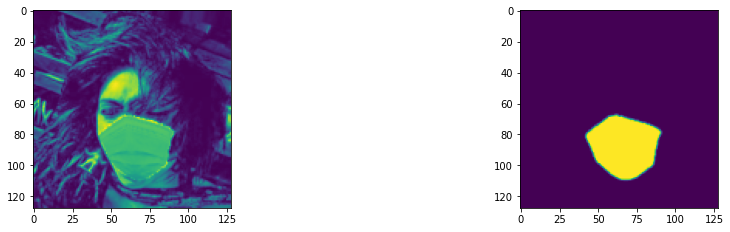

In [22]:
x,y = traindataset.__getitem__(101)
fast_display(x[0],y[0])

In [5]:
os.chdir('MaskTheFace')